### Fig 4c and Supp Fig 7: data efficiency aalysis

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, re, glob


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import FIG_DIR, DATA_DIR
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
from RTI_utils import RTI
import simulation_utils 
from simulation import simulateBCIFitts


# for a reproducible result
np.random.seed(1)

fig_path = FIG_DIR
data_dir = f'{DATA_DIR}/simulator/performance/efficiency/'

In [2]:
labels = ['supervised', 'HMM', 'Click HMM', 'RTI', 'stabilizer']

files  = glob.glob(os.path.join(data_dir, '*.npy'))
idxs   = [int(re.findall('_(\d+).npy', x)[0]) for x in files]
print('Missing:', np.setdiff1d(np.arange(max(idxs)), idxs))

rep_data = list()
for f in files:
    rep_data.extend(np.load(f, allow_pickle=True))


# relabel methods based on HPs:
for x in rep_data:
    if x['method'] == 'RTI' and x['look_back'] == 500:
        x['method'] = 'RTI (long look_back)'
    
    elif x['method'] == 'PRI-T' and x['click_inflection'] != None:
        x['method'] = 'Click PRI-T'
    
    else:
        continue

df = pd.DataFrame(rep_data, columns=['ttt','method','chained', 'nSimSteps'])
df['Trial time (sec)'] = np.vstack(df['ttt'])[:, -1]

Missing: []


## Vanilla HMM vs RTI comparisons

In [3]:
def makeEfficiencyPlot(df, subset_labels, colors):

    cmap      = dict(zip(subset_labels, colors))
    scores_df = df[df['method'].isin(subset_labels)]

    sns.stripplot(data = scores_df, x = 'nSimSteps', y = 'Trial time (sec)', hue_order = subset_labels,
                  hue = 'method', alpha = 0.8, palette = cmap, dodge = True)

    ax = plt.gca()

    sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6,}, whiskerprops={'visible': False},
                zorder=1, x="nSimSteps", y="Trial time (sec)", hue='method', data=scores_df, hue_order = subset_labels,
                showfliers=False, showbox=False, showcaps=False, ax=ax)

    #plt.yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(subset_labels)],labels[:len(subset_labels)], frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

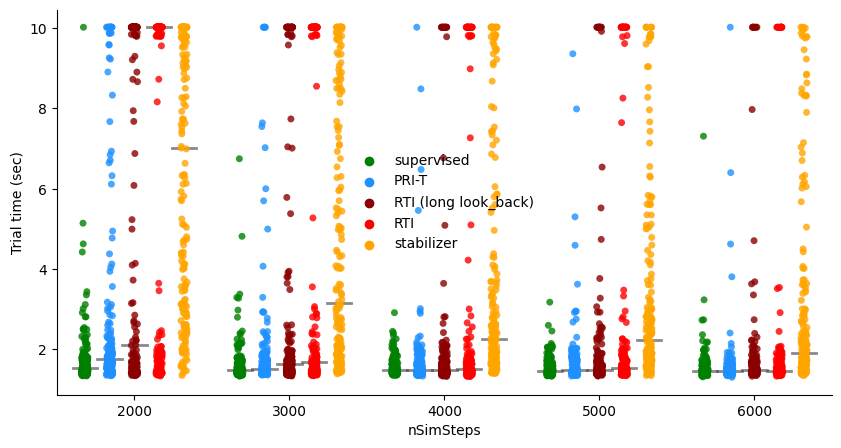

In [4]:
figSize(5, 10)

subset_labels = ['supervised', 'PRI-T', 'RTI (long look_back)', 'RTI', 'stabilizer']
colors = ['g', 'dodgerblue', 'darkred', 'red', 'orange']

makeEfficiencyPlot(df, subset_labels, colors)
plt.savefig(os.path.join(fig_path, 'simulator', 'efficiency_sweep.pdf'), format = 'pdf')

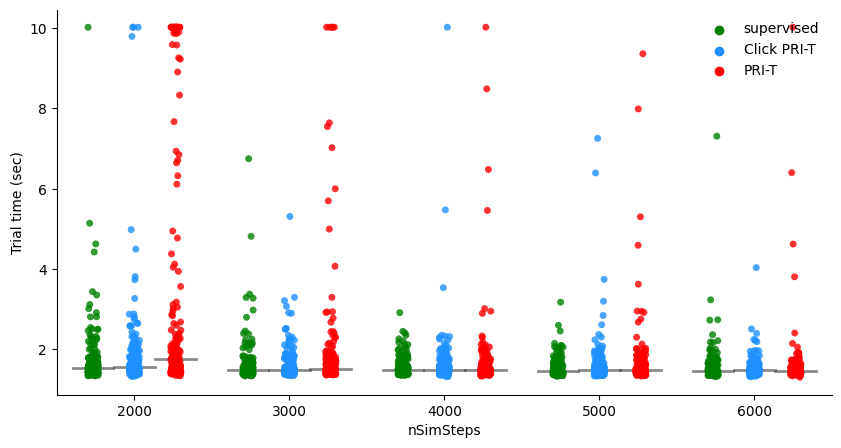

In [5]:
subset_labels = ['supervised', 'Click PRI-T', 'PRI-T']
colors = ['g', 'dodgerblue', 'r']

makeEfficiencyPlot(df, subset_labels, colors)
plt.savefig(os.path.join(fig_path, 'simulator', 'efficiency_sweep_click.pdf'), format = 'pdf')

In [7]:
import scipy.stats

subset_labels = df['method'].unique()

for nSteps in np.unique(df['nSimSteps']):
    subset = df[df['nSimSteps'] == nSteps]
    
    print(' \n ============== Time (sec): ', 0.02 * nSteps, '================')
    for i, method1 in enumerate(subset_labels):
        print(f'{method1}: ', np.mean(subset[subset['method'] == method1]['Trial time (sec)']))
        
    print('\n')
    for i, method1 in enumerate(subset_labels):
        for j, method2 in enumerate(subset_labels):
            if i > j:
                stat = scipy.stats.ranksums(
                    subset.loc[subset['method'] == method1, 'Trial time (sec)'],
                    subset.loc[subset['method'] == method2, 'Trial time (sec)']
                )
                # Determine which method has lower values based on the sign of the statistic
                if stat[0] < 0:
                    lower = method1
                elif stat[0] > 0:
                    lower = method2
                else:
                    lower = "tie"

                print(
                    f"{method1:<20} vs {method2:<20} "
                    f"stat = {stat[0]:8.4f}   p = {stat[1]:8.4f}   lower = {lower}"
                )

 
 ============== Time (sec):  40.0 ================
supervised:  1.7451228378014583
PRI-T:  3.1384648436481695
Click PRI-T:  1.8978717139365335
RTI:  6.698175838998859
RTI (long look_back):  5.061985353869639
stabilizer:  6.3995964652179085


PRI-T                vs supervised           stat =   5.7731   p =   0.0000   lower = supervised
Click PRI-T          vs supervised           stat =   1.7878   p =   0.0738   lower = supervised
Click PRI-T          vs PRI-T                stat =  -4.2957   p =   0.0000   lower = Click PRI-T
RTI                  vs supervised           stat =  10.5013   p =   0.0000   lower = supervised
RTI                  vs PRI-T                stat =   7.1769   p =   0.0000   lower = PRI-T
RTI                  vs Click PRI-T          stat =   9.6848   p =   0.0000   lower = Click PRI-T
RTI (long look_back) vs supervised           stat =   6.8979   p =   0.0000   lower = supervised
RTI (long look_back) vs PRI-T                stat =   2.8171   p =   0.0048   lo